# Simplified Vision Transformer

ViT를 이용한 CIFAR-100(Canadian Institute for Advanced Research, 총 100개의 클래스 또는 범주) 이미지 분류  

### GPU 필요하므로 Colab에서 실행

In [6]:
import numpy as np
import tensorflow as tf
import tensorrt as tr
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [7]:
num_classes = 100
input_shape = (32, 32, 3)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

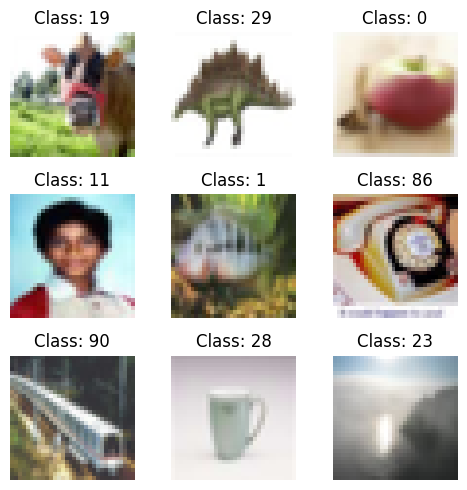

In [8]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {y_train[i][0]}")
    plt.axis('off')
plt.tight_layout()

CIFAR-100 데이터셋은 이미지 크기가 32x32로 상대적으로 작은 이미지로 구성되어 있습니다. 따라서 Vision Transformer 모델을 이 데이터셋에 적용하려면 32x32 이미지를 224x224 크기로 변경하여 패치로 분할하는 것이 일반적입니다. 이렇게 하면 모델이 더 큰 패치에서 특징을 추출하고 이미지 내의 다양한 정보를 고려할 수 있게 됩니다.

In [9]:
# 배치 크기 (한 번에 처리할 이미지 수)
batch_size = 256

# 이미지 크기 (가로와 세로 크기가 동일한 이미지)
image_size = 224

# 이미지를 나눌 패치(patch) 크기
patch_size = 32

# 이미지를 패치로 나눌 때 생성되는 패치 개수
num_patches = (image_size // patch_size) ** 2

# D (임베딩 차원 및 어텐션 헤드 개수 설정)
projection_dim = 64
num_heads = 4

# 트랜스포머 블록 내부의 레이어 유닛 개수 설정
transformer_units = [
    projection_dim * 2,
    projection_dim
]

# 트랜스포머 블록의 층 수 설정
transformer_layers = 12

# MLP 헤드 내부의 레이어 유닛 개수 설정
mlp_head_units = [2048, 1024]

In [10]:
# 데이터 증강을 위한 Keras Sequential 모델을 생성
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),           # 데이터 정규화 (이미지 픽셀 값을 [0, 1] 범위로 조정)
        layers.Resizing(image_size, image_size),       # 이미지 크기를 조정
        layers.RandomFlip('horizontal'),                      # 수평 방향으로 이미지를 무작위로 뒤집기
        layers.RandomRotation(factor=0.02),             # 이미지를 무작위로 회전 (회전 범위는 ±2%)
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # 이미지를 무작위로 확대/축소 (높이와 너비 각각 최대 20%까지)
    ],
    name = 'data_augmentation',              # 이 Sequential 모델의 이름을 'data_augmentation'으로 설정
)

# X_train 데이터셋을 사용하여 정규화 층의 상태를 적응시킵니다.
# 즉, 데이터셋의 평균과 표준편차를 계산하여 정규화 층에 저장합니다.
# 여기의 기능이 뭐지,,,?
data_augmentation.layers[0].adapt(X_train)

In [11]:
# MLP (다층 퍼셉트론) 함수 정의
# 초기 activation = gelu
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

 `tf.image.extract_patches`는 주어진 이미지에서 작은 패치들을 추출  

1. **images**:  `[batch size, height, width, channels]`
2. **sizes**: 추출하고자 하는 패치의 크기. `[1, size_rows, size_cols, 1]`의 shape.  
    첫번째 1: batch dimension. 이 함수에서는 한 배치 내에서 한 이미지만 처리하기 때문에 1로 설정.    
    size_rows: 패치의 행 크기.  
    size_cols: 패치의 열 크기.
    마지막 1: 이미지의 채널 수. tf.image.extract_patches 함수에서는 모든 채널에 대한 패치를 동시에 추출하기 때문에 이 값은 항상 1로 설정.

3. **strides**: 두 연속적인 패치의 중심 간의 간격을 나타내는 4차원 텐서입니다. `[1, stride_rows, stride_cols, 1]`의 형태를 가지며, 실질적으로 `stride_rows`와 `stride_cols`만 주요하게 사용됩니다.

4. **rates**: 패치 추출 시 샘플링 간격을 조절.  `[1, 1, 1, 1]` 값은 일반적인 샘플링을 의미.

5. **padding**:  'VALID'는 이미지 내에서 완전히 포함된 패치만 포함


In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        # 입력 이미지의 배치 크기를 가져옴
        batch_size = tf.shape(images)[0]
        print(tf.shape)
        # 이미지에서 패치를 추출
        patches = tf.image.extract_patches(
            images = images,
            # 패치의 크기를 지정
            sizes = [1, self.patch_size, self.patch_size, 1],
            # 패치를 추출할 때의 간격을 지정
            strides = [1, self.patch_size, self.patch_size, 1],
            # 패치 추출 시의 비율을 지정 (변경 없음)
            # 1개 픽셀을 1개로 추출출
            rates = [1, 1, 1, 1],
            # 패딩 방식을 지정 (추출되는 패치가 이미지 경계 내에 완전히 있어야 함)
            padding="VALID",
        )
        # 추출된 패치의 차원을 가져옴 --> (batch_size, 7, 7, 3072)
        # 3072에 32 x 32 x 3의 정보가 모두 들어있음
        # 그것이 49장의 패치로 나뉜 것것
        patch_dims = patches.shape[-1]
        print(patches.shape)
        # 패치의 형태를 reshape하여 반환 --> (batch_size, 49, 3072)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        print(patches.shape)
        return patches

### 학습 데이터 시각화
본래의 32X32 image를 224X224 로 resize 하였으므로 사진이 흐릿하게 보일것임.

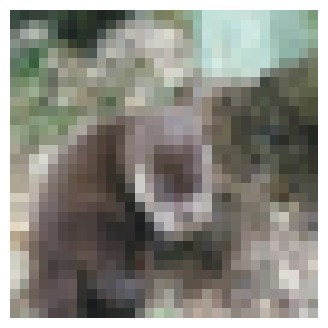

In [13]:
plt.figure(figsize=(4, 4))

# 학습 데이터셋에서 랜덤하게 이미지 하나를 선택
image = X_train[np.random.choice(range(X_train.shape[0]))]

# 선택된 이미지 시각화
plt.imshow(image.astype('uint8'))
plt.axis('off')

# 이미지의 크기 조절
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

In [14]:
patch_size

32

<function shape_v2 at 0x7f893e165a60>
(1, 7, 7, 3072)
(1, 49, 3072)
Image 크기: 224 X 224
Patch 크기: 32 X 32
이미지당 patch 수: 49
patch당 element 갯수: 3072
Shape of patch: (1, 49, 3072)


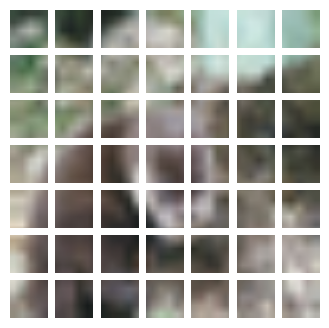

In [15]:
# Patches 클래스의 인스턴스를 생성하고 resized_image를 통과시켜 패치들을 생성
patches = Patches(patch_size)(resized_image)

# 이미지와 패치의 정보 출력
print(f'Image 크기: {image_size} X {image_size}')
print(f'Patch 크기: {patch_size} X {patch_size}')
print(f'이미지당 patch 수: {patches.shape[1]}')
print(f'patch당 element 갯수: {patches.shape[-1]}')
print(f'Shape of patch: {patches.shape}')

# 패치들을 시각화
# 패치들의 수의 제곱근으로 n 설정 (예: 패치가 16개라면 4x4로 시각화)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

### PatchEncoder 정의
- Vision Transformer (ViT) 모델의 핵심 구성 요소 중 하나인 PatchEncoder 클래스를 정의  
- 이 클래스는 패치를 인코딩하고 위치 정보를 임베딩

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches  # 전체 패치의 수 저장

        # 실수 값을 입력으로 받아 선형 변환을 수행하여 projection_dim으로 투영
        self.projection = layers.Dense(projection_dim)

        # 정수 인덱스를 입력으로 받아 해당 인덱스에 대응되는 임베딩 벡터 출력
        self.position_embedding = layers.Embedding(
            input_dim=num_patches,  # 입력 차원은 전체 패치의 수와 동일
            output_dim=projection_dim  # 출력 차원은 projection_dim과 동일
        )

    def call(self, patch):
        # 예: num_patches = 5 -> position = [0, 1, 2, 3, 4]
        position = tf.range(start=0, limit=self.num_patches, delta=1)

        # 패치를 투영하고 위치 임베딩을 더해 최종 인코딩된 결과를 반환
        
        encoded = self.projection(patch) + self.position_embedding(position)

        return encoded

<img src="https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png" width=700 />

In [17]:
def vit():
    inputs = layers.Input(shape=input_shape)
    # 데이터 증강 레이어를 통과
    augmented = data_augmentation(inputs)
    # 입력 이미지를 패치로 분할
    patches = Patches(patch_size)(augmented)
    # 패치 인코더를 통해 패치를 임베딩
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer 블록을 transformer_layers 횟수만큼 반복
    for _ in range(transformer_layers):
        # Layer Normalization 적용
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # 멀티 헤드 어텐션 적용
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # 어텐션 결과와 인코딩된 패치를 더함
        x2 = layers.Add()([attention_output, encoded_patches])
        # 또 다시 Layer Normalization 적용
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP 적용
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # MLP 결과와 x2를 더함
        encoded_patches = layers.Add()([x3, x2])

    # 임베딩된 패치에 Layer Normalization 적용
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # 텐서를 1차원으로 펼침
    representation = layers.Flatten()(representation)
    # Dropout 적용
    representation = layers.Dropout(0.5)(representation)
    # MLP를 사용하여 특징 추출
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # 마지막 Dense 레이어를 통해 로짓을 계산
    logits = layers.Dense(num_classes)(features)
    # 모델을 생성하고 반환
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
model = vit()
model.summary()

<function shape_v2 at 0x7f893e165a60>
(None, 7, 7, 3072)
(None, None, 3072)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 3)          7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 3072)           0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (Pa

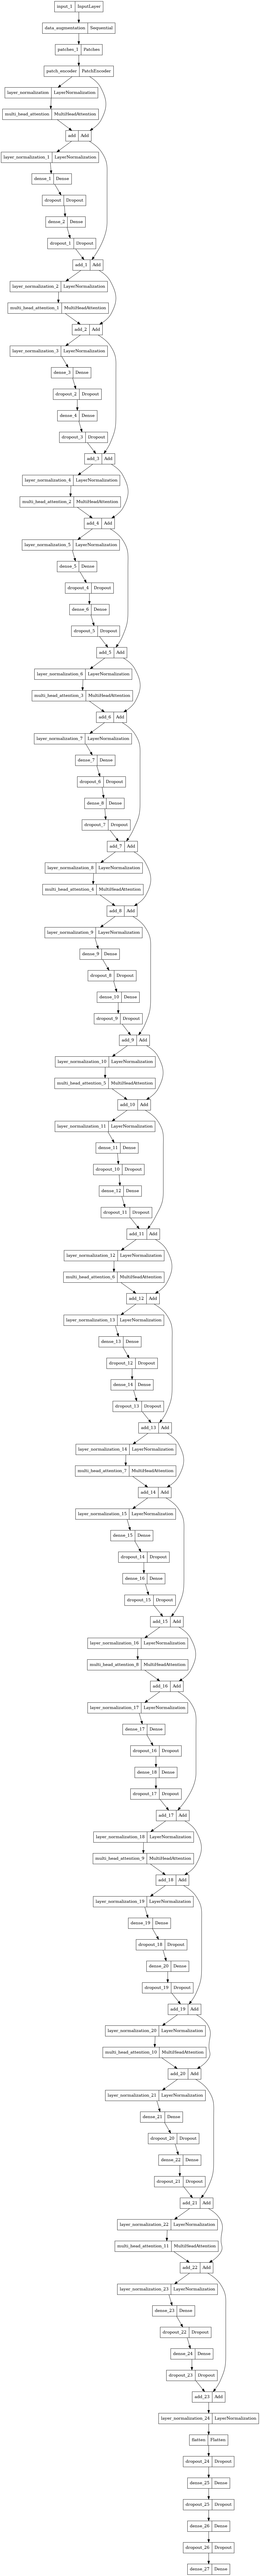

In [19]:
plot_model(model)

Top-k 정확도는 다중 클래스 분류 문제에서 모델의 성능을 측정하는 지표 중 하나로, 모델이 예측한 클래스 중 상위 k개의 예측 중에 정답 클래스가 포함된 비율.  주로 이미지 분류와 같이 클래스 수가 많고 모델이 상위 몇 개의 가능성 있는 클래스를 예측할 수 있는 경우에 유용.

In [20]:
%%time
num_epochs = 2         # 에포크 수 (전체 데이터셋 학습 횟수)
weight_decay = 0.001     # 가중치 감소 값
learning_rate = 0.001    # 학습률

optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')  # 상위 5개 예측 내에서의 정확도
    ]
    )

# 모델 학습
history = model.fit(
    x = X_train, y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1
)

Epoch 1/2
<function shape_v2 at 0x7f893e165a60>
(None, 7, 7, 3072)
(None, None, 3072)
<function shape_v2 at 0x7f893e165a60>
(None, 7, 7, 3072)
(None, None, 3072)


2024-11-14 19:33:47.955681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-14 19:33:48.097444: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa4f78e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 19:33:48.097498: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-14 19:33:48.149999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 19:33:48.228077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-14 19:33:48.478694: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of

176/176 [==============================] - ETA: 0s - loss: 4.3944 - accuracy: 0.0546 - top-5-accuracy: 0.1836<function shape_v2 at 0x7f893e165a60>
(None, 7, 7, 3072)
(None, None, 3072)
176/176 [==============================] - 46s 158ms/step - loss: 4.3944 - accuracy: 0.0546 - top-5-accuracy: 0.1836 - val_loss: 3.8186 - val_accuracy: 0.1276 - val_top-5-accuracy: 0.3410
Epoch 2/2
176/176 [==============================] - 27s 154ms/step - loss: 3.8971 - accuracy: 0.1031 - top-5-accuracy: 0.3096 - val_loss: 3.5577 - val_accuracy: 0.1648 - val_top-5-accuracy: 0.4200
CPU times: user 53 s, sys: 14 s, total: 1min 7s
Wall time: 1min 13s


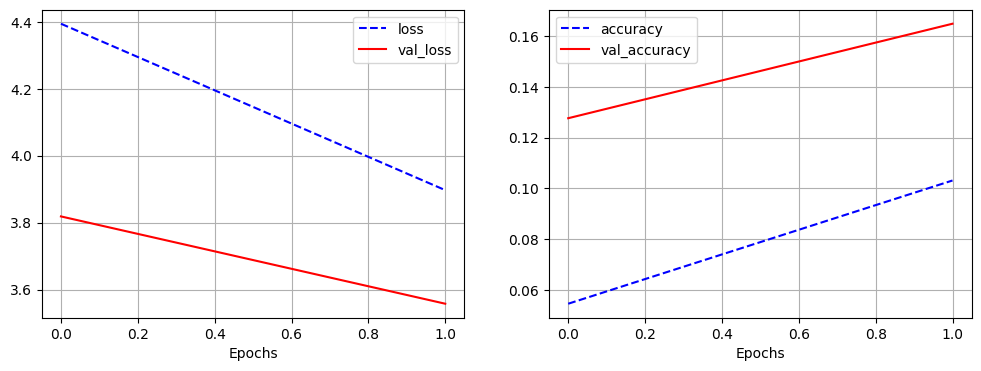

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

### 논문의 benchmark 결과에 의하면 Cifar100 에서 94% 이상의 accuracy 달성